# Variational Algorithms

## Reference States

### Classical Reference State

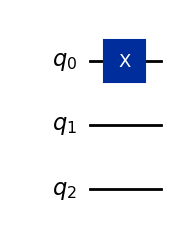

In [3]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(3)
qc.x(0)

qc.draw("mpl")

### Quantum Reference State

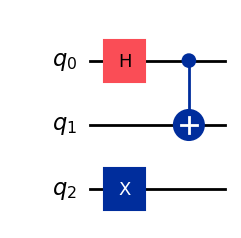

In [4]:
qc = QuantumCircuit(3)
qc.h(0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

### Constructing Reference States using template circuits

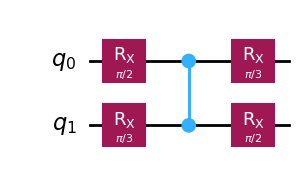

In [5]:
from qiskit.circuit.library import TwoLocal
from math import pi

reference_circuit = TwoLocal(2, "rx", "cz", entanglement="linear", reps=1)
theta_list = [pi / 2, pi / 3, pi / 3, pi / 2]

reference_circuit = reference_circuit.assign_parameters(theta_list)

reference_circuit.decompose().draw("mpl")

### Application-specific reference states

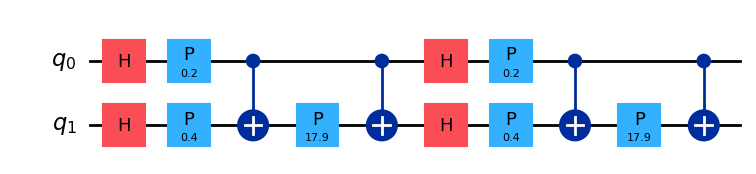

In [6]:
from qiskit.circuit.library import ZZFeatureMap

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)
zz_feature_map_reference.decompose().draw("mpl")

## Ansatze and Variational Forms

### Parameterized Quantum Circuits

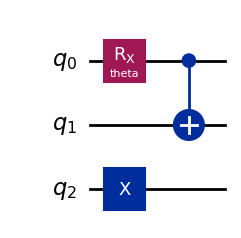

In [7]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("theta")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

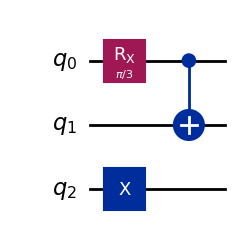

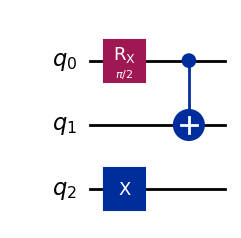

In [8]:
from math import pi

angle_list = [pi / 3, pi / 2]
circuits = [qc.assign_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl"))

### Heuristic ansatze and trade-offs

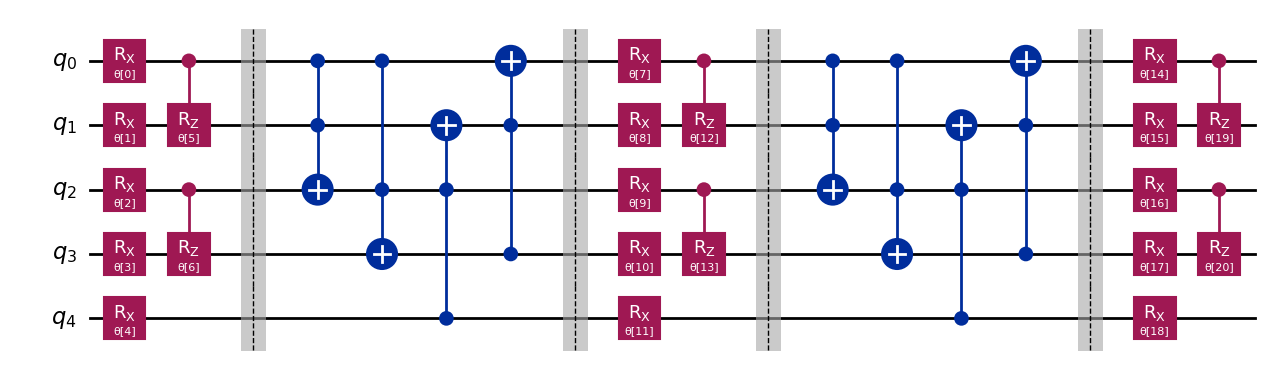

In [9]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

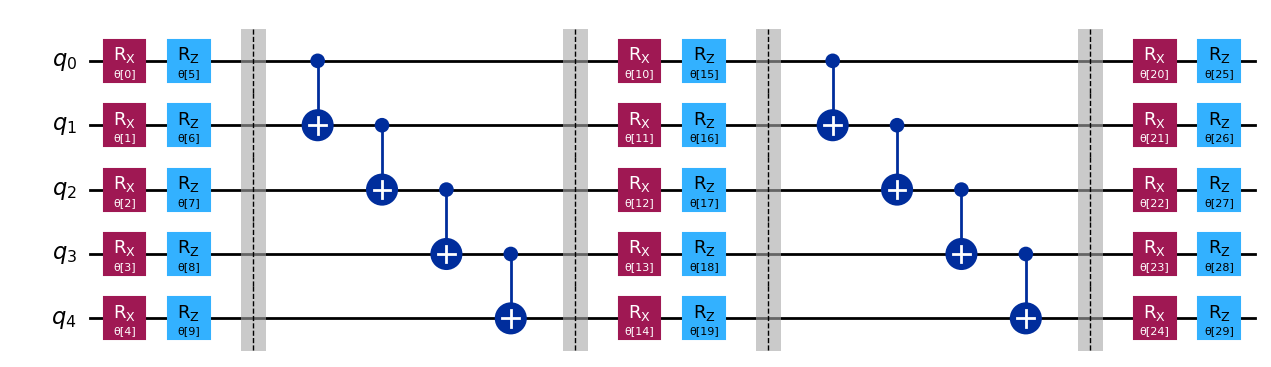

In [10]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

### Efficient SU2

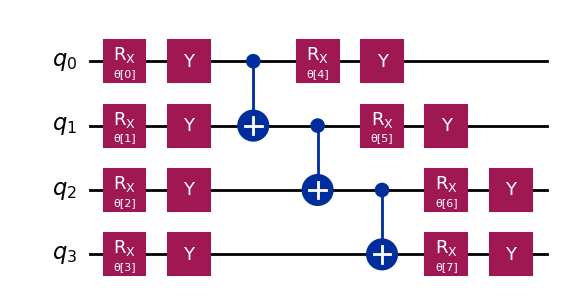

In [11]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

### Problem specific Ansatze

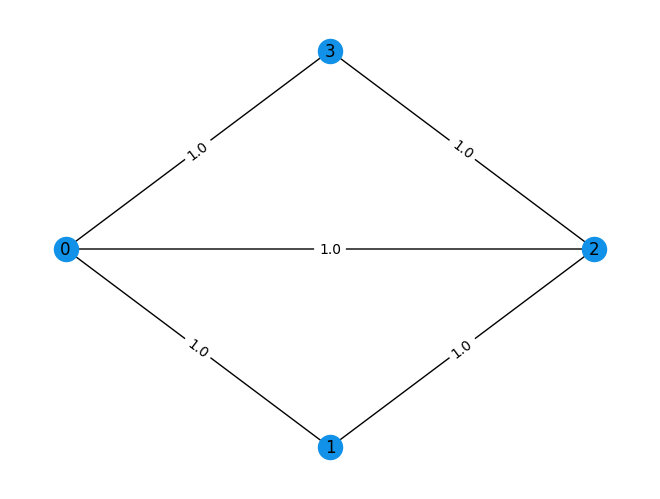

In [12]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

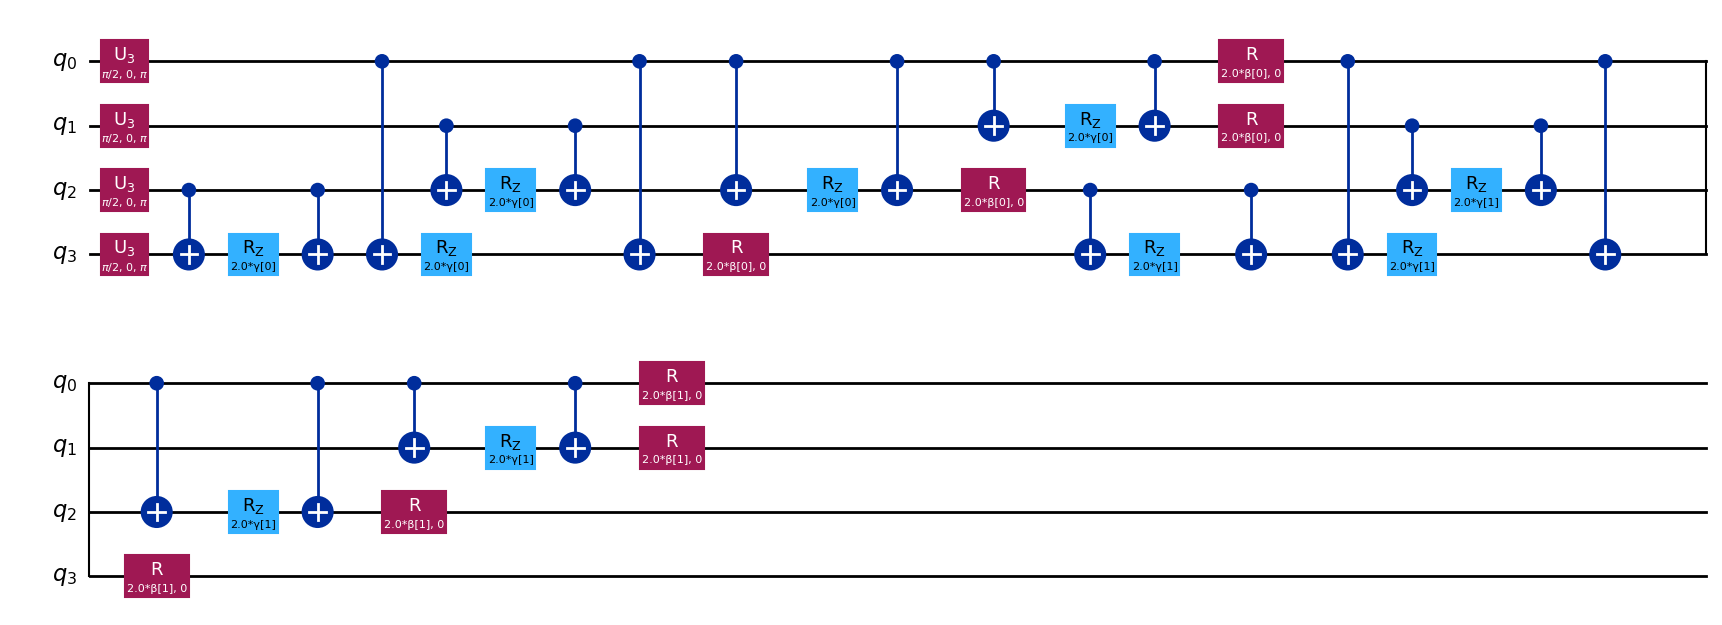

In [13]:
# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("ZZII", 1), ("IZZI", 1), ("ZIIZ", 1), ("IZIZ", 1), ("IIZZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

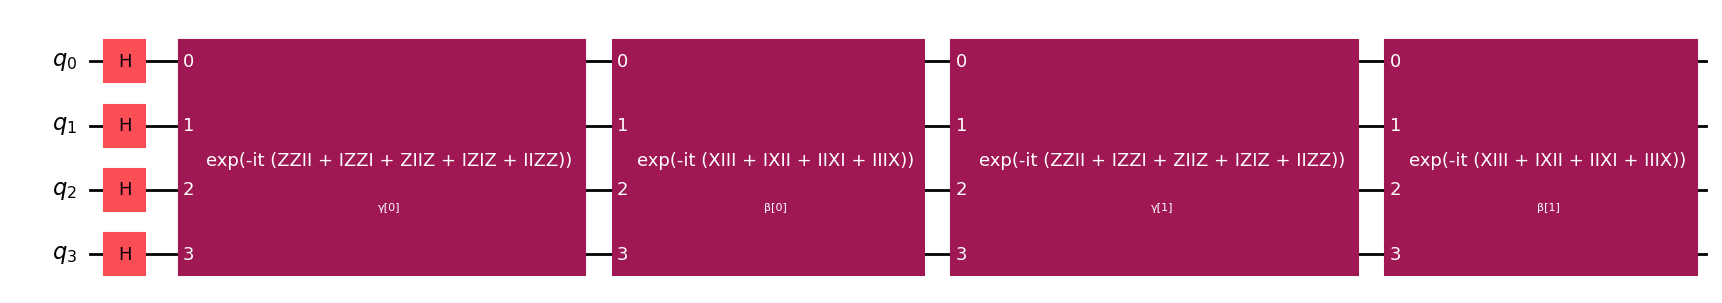

In [14]:
ansatz.decompose(reps=1).draw("mpl")

### Quantum Machine Learning

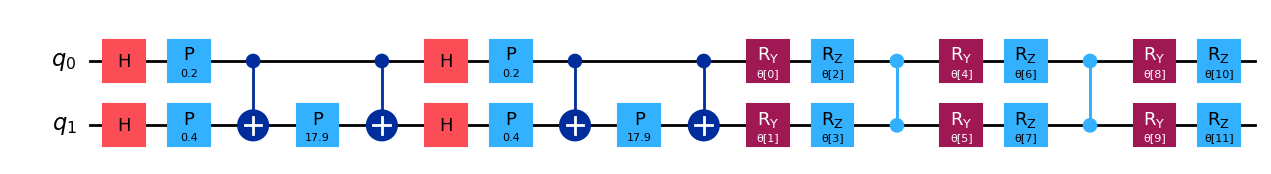

In [15]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)

variation_form = TwoLocal(2, ["ry", "rz"], "cz", reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw("mpl")

## Cost Functions

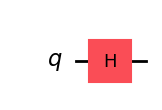

In [16]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl")

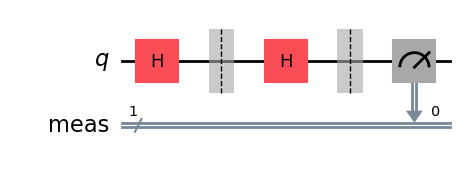

In [17]:
# Auxiliary circuit for X
aux_circuits[0].draw('mpl')

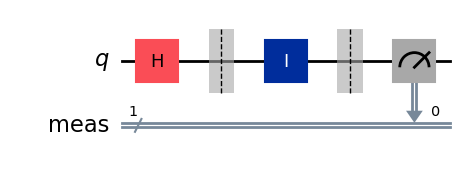

In [18]:
# Auxiliary circuit for Z
aux_circuits[1].draw('mpl')

In [19]:
from qiskit.primitives import StatevectorSampler, StatevectorEstimator
from qiskit.result import QuasiDistribution
from qiskit.circuit.library import IGate, ZGate, XGate, YGate
import numpy as np


## SAMPLER
shots = 10000
sampler = StatevectorSampler()
job = sampler.run(aux_circuits, shots = shots)
data_pub = job.result()[1].data
bitstrings = data_pub.meas.get_bitstrings()
counts = data_pub.meas.get_counts()
quasi_dist = QuasiDistribution({outcome: freq / shots for outcome, freq in counts.items()})

expvals = []
for pauli in H.paulis:
    val = 0
    
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    
    if str(pauli) == "X":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * quasi_dist.get(1)
        val += Lambda[1][0] * quasi_dist.get(0)
    
    if str(pauli) == "Y":
        Lambda = XGate().to_matrix().real
        val += Lambda[0][1] * 1.j * quasi_dist.get(1)
        val += Lambda[1][0] * -1.j * quasi_dist.get(0)

    if str(pauli) == "Z":
        Lambda = ZGate().to_matrix().real
        val += Lambda[0][0] * quasi_dist.get(0)
        val += Lambda[1][1] * quasi_dist.get(1)
    
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,H
]  # Note: run for individual Paulis as well as full observable H

estimator = StatevectorEstimator()
job = estimator.run([(original_circuit, observables)])
estimator_expvals = job.result()[0].data.evs

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00220
  >> Total expected value: 1.99780
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


In [20]:
def cost_func_vqe(params, circuit, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (circuit, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs

#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

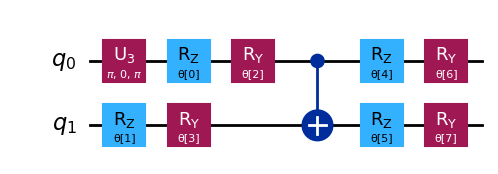

In [21]:
from qiskit.circuit.library import TwoLocal

observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
#ansatz.assign_parameters(theta_list)
#print(ansatz.num_parameters)
ansatz.decompose().draw('mpl')

In [22]:
estimator = StatevectorEstimator()
cost = cost_func_vqe(theta_list, ansatz, observable, estimator)
print(cost)

[-0.56653189]


In [23]:
#Estimated usage: < 1 min. Benchmarked at 7 seconds on ibm_osaka, 5-23-24
#Load necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

#Select the least busy backend:

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)

#Open a Runtime session:

session = Session(backend=backend)

# Use estimator to get the expected values corresponding to the ansatz

estimator = Estimator(session=session)
cost = cost_func_vqe(theta_list, isa_ansatz, isa_observable, estimator)

# Close session after done
session.close()
print(cost)

C:\Users\nihar\AppData\Local\Temp\ipykernel_2120\1844422016.py:26: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


[-0.5812369]


### Example mapping to non-physical systems

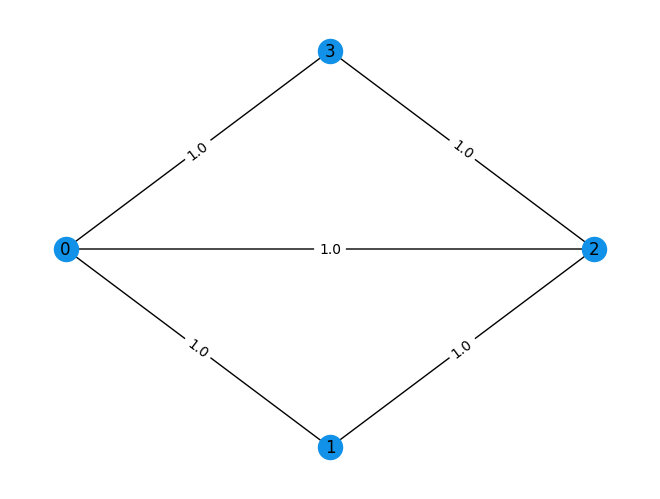

In [24]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

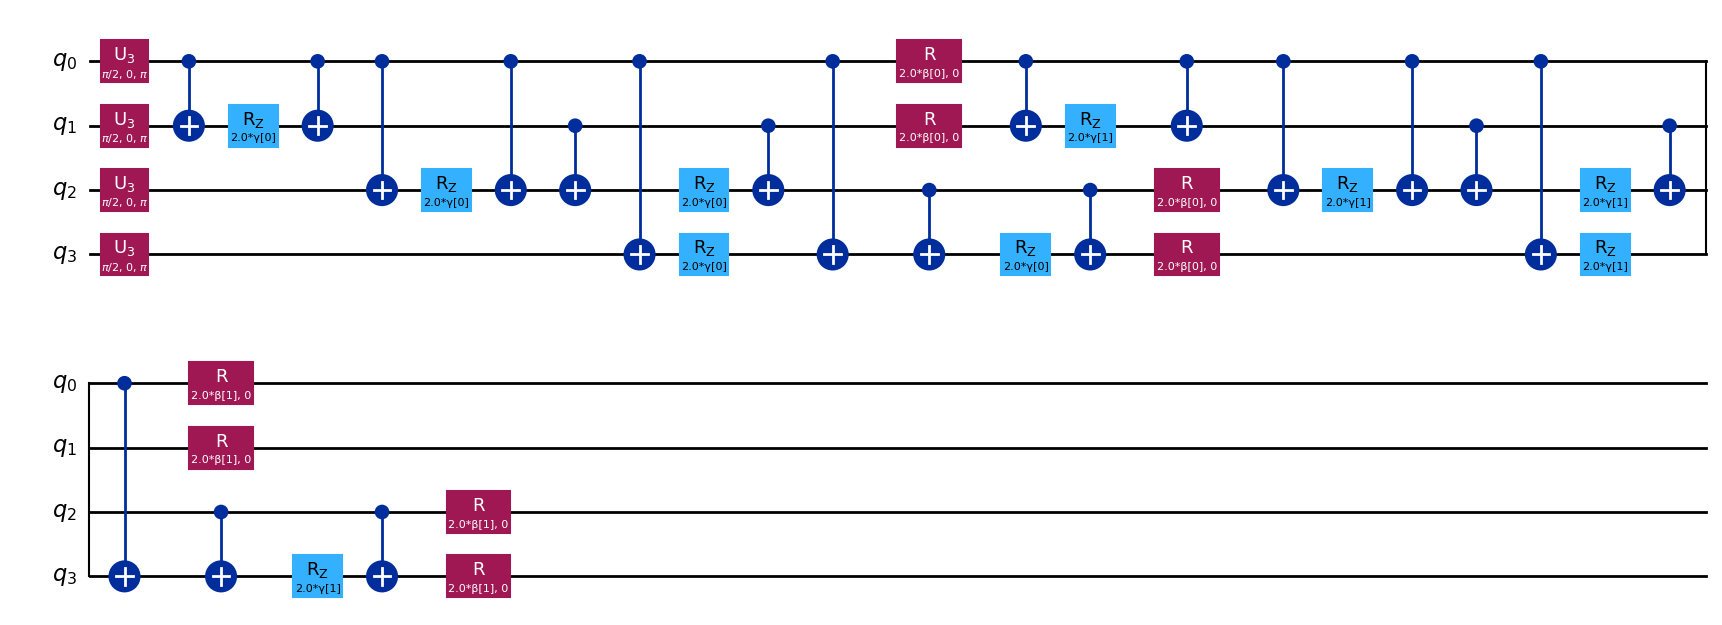

In [25]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])


ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

In [26]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [27]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
#    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [28]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

estimator = StatevectorEstimator()
cost = cost_func_vqe(x0, ansatz, hamiltonian, estimator)
print(cost)

-1.1103211021169703


In [29]:
#Estimated usage: < 1 min, benchmarked at 6 seconds on ibm_osaka, 5-23-24
#Load some necessary packages:

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator

#Select the least busy backend:

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Use a pass manager to transpile the circuit and observable for the specific backend being used:

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_ansatz = pm.run(ansatz)
isa_hamiltonian = hamiltonian.apply_layout(layout = isa_ansatz.layout)

#Open a Runtime session:

session = Session(backend=backend)

# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

cost = cost_func_vqe(x0, isa_ansatz, isa_hamiltonian, estimator)

# Close session after done
session.close()
print(cost)

C:\Users\nihar\AppData\Local\Temp\ipykernel_2120\1504715366.py:24: DeprecationWarning: The 'session' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(session=session)


KeyboardInterrupt: 

### Error Suppression

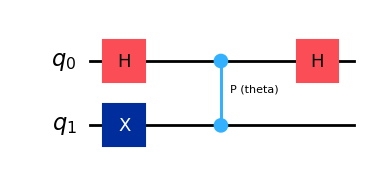

In [30]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl")

In [31]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2*np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

In [32]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator

# get a real backend from the runtime service
service = QiskitRuntimeService()
backend = service.get_backend('ibm_sherbrooke')
 
# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

C:\Users\nihar\AppData\Local\Temp\ipykernel_2120\2846668953.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend('ibm_sherbrooke')


In [33]:
#Import estimator and specify that we are using the simulated backend:

from qiskit_ibm_runtime import EstimatorV2 as Estimator
estimator = Estimator(backend = backend_sim)

circuit = qc

#Use a pass manager to transpile the circuit and observable for the backend being simulated.
#Start with no optimization:

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=0)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

noisy_exp_values = []
pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
noisy_exp_values = cost[0]

#Repeat above steps, but now with optimization = 3:

exp_values_with_opt_es = []
pm = generate_preset_pass_manager(backend=backend_sim, optimization_level=3)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

pub = (isa_circuit, isa_observables, [individual_phases])
cost = estimator.run([pub]).result()[0].data.evs
exp_values_with_opt_es = cost[0]

C:\Users\nihar\AppData\Local\Temp\ipykernel_2120\1784372917.py:4: DeprecationWarning: The 'backend' keyword arguments are deprecated as of qiskit-ibm-runtime 0.24.0 and will be removed no sooner than 3 months after the release date. Please use the 'mode' parameter instead.
  estimator = Estimator(backend = backend_sim)


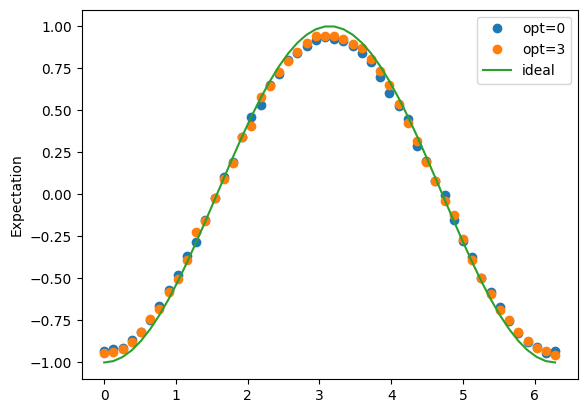

In [34]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="opt=0")
plt.plot(phases, exp_values_with_opt_es, "o", label="opt=3")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

### Error mitigatiion
### Zero noise extrapolation

In [35]:
# Estimated usage: 8 minutes, benchmarked on ibm_sherbrooke, 5-23-24

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Options, Session, EstimatorV2 as Estimator

# We select the least busy backend

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

#Initialize some variables to save the results from different runs:

exp_values_with_em0_es = []
exp_values_with_em1_es = []
exp_values_with_em2_es = []

#Use a pass manager to optimize the circuit and observables for the backend chosen:

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(circuit)
isa_observables = observables.apply_layout(layout = isa_circuit.layout)

# Open a session and run with no error mitigation:

with Session(backend=backend) as session:
    session_options = Options()
    session_options.execution.shots = 2000
    session_options.resilience_level = 0

    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em0_es = cost[0]

# Open a session and run with resilience = 1:

with Session(backend=backend) as session:
    session_options = Options()
    session_options.execution.shots = 2000
    session_options.resilience_level = 1

    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em1_es = cost[0]

# Open a session and run with resilience = 2:

with Session(backend=backend) as session:
    session_options = Options()
    session_options.execution.shots = 2000
    session_options.resilience_level = 2

    estimator = Estimator(session=session)
    estimator.options.default_shots = 10_000
    
    pub = (isa_circuit, isa_observables, [individual_phases])
    cost = estimator.run([pub]).result()[0].data.evs

session.close()

exp_values_with_em2_es = cost[0]

AttributeError: 'OptionsV2' object has no attribute 'execution'

ValueError: x and y must have same first dimension, but have shapes (50,) and (0,)

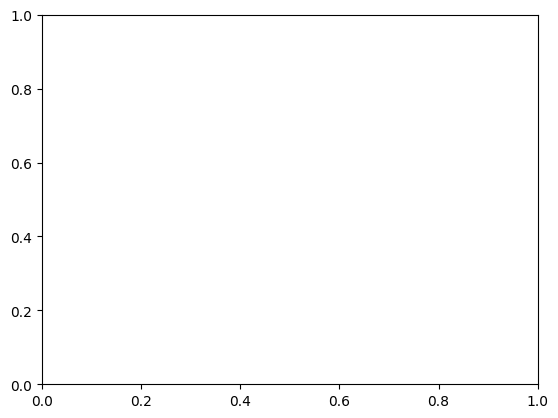

In [36]:
import matplotlib.pyplot as plt

plt.plot(phases, exp_values_with_em0_es, "o", label="unmitigated")
plt.plot(phases, exp_values_with_em1_es, "o", label="resil = 1")
plt.plot(phases, exp_values_with_em2_es, "o", label="resil = 2")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="ideal")
plt.ylabel("Expectation")
plt.legend()
plt.show()

In [37]:
import qiskit
import qiskit_ibm_runtime
print(qiskit.version.get_version_info())
print(qiskit_ibm_runtime.version.get_version_info())

1.2.0
0.28.0


## Optimization Loops

### Local and Global Optimizers

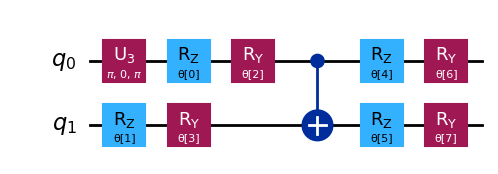

In [38]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [39]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    pub = (ansatz, hamiltonian, params)
    cost = estimator.run([pub]).result()[0].data.evs
    return cost

In [40]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

### Local Optimizers

In [42]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="SLSQP")

result

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.99999999645274
       x: [ 1.000e+00  1.000e+00 -1.571e+00 -4.556e-05 -1.207e+00
           -1.935e+00  4.079e-01 -4.079e-01]
     nit: 12
     jac: [ 1.192e-07  2.980e-08 -7.959e-04  2.543e-04  1.381e-03
            1.381e-03  5.431e-04  5.431e-04]
    nfev: 112
    njev: 12

## Gradient-Based and Gradient-free optimizers

### Gradient-based

In [43]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="BFGS")

result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.999999999999782
        x: [ 1.000e+00  1.000e+00  1.571e+00  2.785e-07  2.009e-01
            -2.009e-01  6.342e-01 -6.342e-01]
      nit: 14
      jac: [ 5.960e-08 -2.980e-08  8.941e-07  1.013e-06  2.086e-07
             1.490e-07  5.960e-08  5.960e-08]
 hess_inv: [[ 1.000e+00 -2.999e-08 ... -7.780e-05 -6.011e-05]
            [-2.999e-08  1.000e+00 ... -3.475e-06 -7.574e-07]
            ...
            [-7.780e-05 -3.475e-06 ...  7.242e-01 -2.603e-01]
            [-6.011e-05 -7.574e-07 ... -2.603e-01  8.180e-01]]
     nfev: 144
     njev: 16

### Gradient-free

In [44]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.9999999832448676
       x: [ 1.687e+00  1.250e+00  1.571e+00  3.142e+00  1.469e+00
           -1.672e+00  1.556e+00  1.585e+00]
    nfev: 126
   maxcv: 0.0

# Instances and Extensions

## Variational Quantum Eigensolver (VQE)

### VQE Implementation

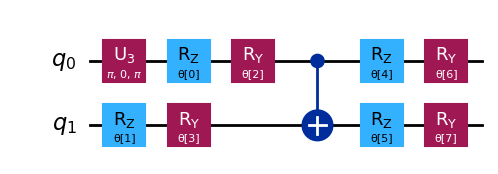

In [45]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal
import numpy as np

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable=SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl')

In [46]:
def cost_func_vqe(parameters, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])
    estimator_result = estimator_job.result()[0]

    cost = estimator_result.data.evs[0]
    return cost

In [47]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [48]:
# SciPy minimizer routine
from scipy.optimize import minimize

x0 = np.ones(8)

result = minimize(cost_func_vqe, x0, args=(ansatz, observable, estimator), method="COBYLA")

result

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999988971083
       x: [ 1.779e+00  9.443e-01  1.571e+00  2.105e-05  1.938e+00
            1.204e+00  6.059e-01  6.059e-01]
    nfev: 136
   maxcv: 0.0

In [49]:
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, Options
from qiskit_ibm_runtime import QiskitRuntimeService


service = QiskitRuntimeService(channel='ibm_quantum')
backend = service.least_busy(operational=True, simulator=False)

In [50]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_observable = observable.apply_layout(layout = isa_ansatz.layout)

In [ ]:
#Estimated required time: <20 min. Benchmarked at 17 min, 40 s on ibm_osaka, on 5-29-24

x0 = np.ones(8)

with Session(backend=backend) as session:
    session_options = Options()
    session_options.execution.shots = 4096
    session_options.resilience_level = 1

    estimator = Estimator(session=session)
    sampler = Sampler(session = session)
    estimator.options.default_shots = 10_000
    
    result = minimize(cost_func_vqe, x0, args=(isa_ansatz, isa_observable, estimator), method="COBYLA")

session.close()
print(result)

ValidationError: 1 validation error for OptionsV2
shots
  Object has no attribute 'shots' [type=no_such_attribute, input_value=4096, input_type=int]
    For further information visit https://errors.pydantic.dev/2.8/v/no_such_attribute

### SSVQE

In [53]:
import numpy as np

def cost_func_ssvqe(params, initialized_anastz_list, weights, ansatz, hamiltonian, estimator):
    # """Return estimate of energy from estimator

    # Parameters:
    #     params (ndarray): Array of ansatz parameters
    #     initialized_anastz_list (list QuantumCircuit): Array of initialised ansatz with reference
    #     weights (list): List of weights
    #     ansatz (QuantumCircuit): Parameterized ansatz circuit
    #     hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
    #     estimator (Estimator): Estimator primitive instance

    # Returns:
    #     float: Weighted energy estimate
    # """

    energies = []

    # Define SSVQE

    weighted_energy_sum = np.dot(energies, weights)
    return weighted_energy_sum

### Variational Quantum Deflation (VQD)

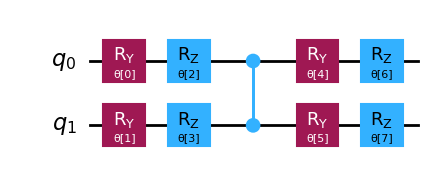

In [54]:
from qiskit.circuit.library import TwoLocal

raw_ansatz = TwoLocal(2, rotation_blocks=["ry", "rz"], entanglement_blocks="cz", reps=1)

raw_ansatz.decompose().draw('mpl')

In [60]:
import numpy as np

def calculate_overlaps(ansatz, prev_circuits, parameters, sampler):

    def create_fidelity_circuit(circuit_1, circuit_2):

        """
        Constructs the list of fidelity circuits to be evaluated.
        These circuits represent the state overlap between pairs of input circuits,
        and their construction depends on the fidelity method implementations.
        """
                
        if len(circuit_1.clbits) > 0:
            circuit_1.remove_final_measurements()
        if len(circuit_2.clbits) > 0:
            circuit_2.remove_final_measurements()

        circuit = circuit_1.compose(circuit_2.inverse())
        circuit.measure_all()
        return circuit
    overlaps = []

    for prev_circuit in prev_circuits:
        fidelity_circuit = create_fidelity_circuit(ansatz, prev_circuit)
        sampler_job = sampler.run([(fidelity_circuit, parameters)])
        meas_data = sampler_job.result()[0].data.meas
        
        counts_0 = meas_data.get_int_counts().get(0, 0)
        shots = meas_data.num_shots
        overlap = counts_0/shots
        overlaps.append(overlap)
    
    return np.array(overlaps)

In [61]:
def cost_func_vqd(parameters, ansatz, prev_states, step, betas, estimator, sampler, hamiltonian):

    estimator_job = estimator.run([(ansatz, hamiltonian, [parameters])])

    total_cost = 0

    if step > 1:
        overlaps = calculate_overlaps(ansatz, prev_states, parameters, sampler)
        total_cost = np.sum([np.real(betas[state] * overlap) for state, overlap in enumerate(overlaps)])

    estimator_result = estimator_job.result()[0]

    value = estimator_result.data.evs[0] + total_cost

    return value

In [62]:
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.primitives import StatevectorEstimator as Estimator
sampler = Sampler()
estimator = Estimator()

In [63]:
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp.from_list([("II", 2), ("XX", -2), ("YY", 3), ("ZZ", -3)])

In [64]:
k = 3
betas = [33, 33, 33]
x0 = np.zeros(8)

In [65]:
from scipy.optimize import minimize

prev_states = []
prev_opt_parameters = []
eigenvalues = []

for step in range(1, k + 1):
    
    if step > 1:
        prev_states.append(ansatz.assign_parameters(prev_opt_parameters))
    
    result = minimize(cost_func_vqd, x0, args=(ansatz, prev_states, step, betas, estimator, sampler, observable), method="COBYLA", options={'maxiter': 200,})
    print(result)

    prev_opt_parameters = result.x
    eigenvalues.append(result.fun)

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -5.999999983468767
       x: [-5.092e-01 -5.806e-02 -1.571e+00 -1.722e-05  2.688e-01
           -2.688e-01 -8.556e-01 -8.555e-01]
    nfev: 125
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 4.025471915908117
       x: [ 1.719e-01 -3.279e-01  1.567e+00 -5.447e-02  5.202e-03
            5.401e-02  3.745e-02 -3.008e-01]
    nfev: 99
   maxcv: 0.0
 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: 5.923215165670577
       x: [ 1.464e+00 -7.677e-01 -1.584e+00 -6.150e-02  6.260e-01
            1.752e+00  3.236e+00 -2.544e-01]
    nfev: 86
   maxcv: 0.0
